<a href="https://colab.research.google.com/github/MohammedKhrishi/AI-Based-Model-Coupled-To-MatPower-Simulation-Framework/blob/main/LSTM_phase_allocation_with_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

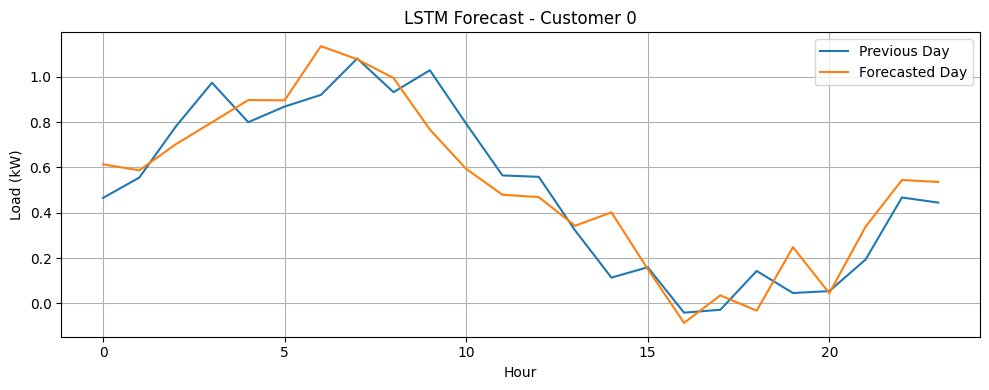

In [1]:
# Step 1: Install and import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# Step 2: Generate synthetic load profiles (30 days, 24 hours/day, 10 customers)
days = 30
n_customers = 10
time_steps = 24
np.random.seed(0)

load_data = []
for i in range(n_customers):
    customer_data = []
    for d in range(days):
        base = 0.5 + 0.5 * np.sin(np.linspace(0, 2*np.pi, time_steps))
        noise = np.random.normal(0, 0.1, time_steps)
        day_profile = base + noise + (i % 3) * 0.2
        customer_data.append(day_profile)
    load_data.append(np.array(customer_data))

# Step 3: Focus on one customer's data
customer_id = 0
customer_series = load_data[customer_id]

# Normalize the series
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(customer_series)

# Step 4: Create sequences (last 5 days → next day)
def create_sequences(data, input_days=5):
    X, y = [], []
    for i in range(len(data) - input_days):
        X.append(data[i:i+input_days].reshape(-1))
        y.append(data[i+input_days])
    return np.array(X), np.array(y)

X, y = create_sequences(series_scaled)
X_tensor = torch.tensor(X, dtype=torch.float32).reshape(-1, 5, 24)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Step 5: Define LSTM Model
class LSTMForecast(nn.Module):
    def __init__(self):
        super(LSTMForecast, self).__init__()
        self.lstm = nn.LSTM(input_size=24, hidden_size=50, batch_first=True)
        self.fc = nn.Linear(50, 24)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMForecast()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Step 6: Train the model
epochs = 200
for epoch in range(epochs):
    model.train()
    output = model(X_tensor)
    loss = loss_fn(output, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Step 7: Forecast next day
model.eval()
with torch.no_grad():
    last_sequence = torch.tensor(series_scaled[-5:], dtype=torch.float32).reshape(1, 5, 24)
    forecast = model(last_sequence).numpy()

forecast_kw = scaler.inverse_transform(forecast).flatten()

# Step 8: Visualize
plt.figure(figsize=(10, 4))
plt.plot(range(24), customer_series[-1], label='Previous Day')
plt.plot(range(24), forecast_kw, label='Forecasted Day')
plt.xlabel('Hour')
plt.ylabel('Load (kW)')
plt.title('LSTM Forecast - Customer {}'.format(customer_id))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Best phase assignment (0=A, 1=B, 2=C): [2, 1, 0, 1, 0, 2, 1, 0, 2, 1]


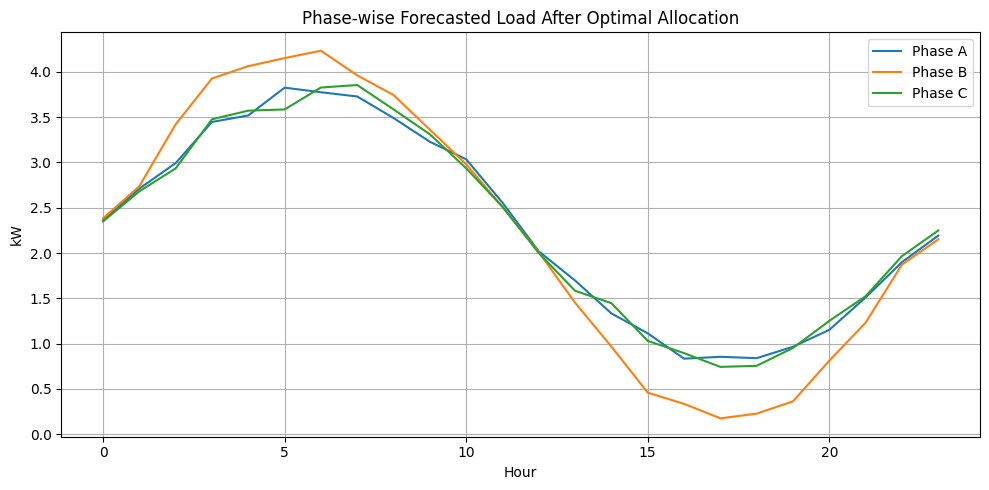

In [2]:
from sklearn.metrics import mean_squared_error
import random

# Step 1: Forecast all 10 customers
forecasted_profiles = []
for i in range(n_customers):
    customer_series = load_data[i]
    scaled = scaler.fit_transform(customer_series)
    X, y = create_sequences(scaled)
    X_tensor = torch.tensor(X, dtype=torch.float32).reshape(-1, 5, 24)

    model = LSTMForecast()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # quick training
    for epoch in range(100):
        model.train()
        output = model(X_tensor)
        loss = loss_fn(output, torch.tensor(y, dtype=torch.float32))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # forecast
    with torch.no_grad():
        last_seq = torch.tensor(scaled[-5:], dtype=torch.float32).reshape(1, 5, 24)
        forecast = model(last_seq).numpy()
        forecast_kw = scaler.inverse_transform(forecast).flatten()
        forecasted_profiles.append(forecast_kw)

forecasted_profiles = np.array(forecasted_profiles)  # shape: (10, 24)

# Step 2: Optimization - Phase Assignment via Genetic Algorithm
def fitness(assignment, loads):
    phase_loads = [np.zeros(24), np.zeros(24), np.zeros(24)]
    for idx, phase in enumerate(assignment):
        phase_loads[phase] += loads[idx]
    imbalances = np.std([np.sum(pl) for pl in phase_loads])
    return imbalances

def mutate(assignment):
    idx = random.randint(0, len(assignment)-1)
    assignment[idx] = random.randint(0, 2)
    return assignment

def crossover(p1, p2):
    point = random.randint(1, len(p1)-1)
    child = p1[:point] + p2[point:]
    return child

# Initial population
pop_size = 30
population = [ [random.randint(0, 2) for _ in range(n_customers)] for _ in range(pop_size)]

# Run GA
generations = 100
for gen in range(generations):
    population.sort(key=lambda x: fitness(x, forecasted_profiles))
    new_pop = population[:10]  # elitism

    while len(new_pop) < pop_size:
        p1, p2 = random.sample(population[:15], 2)
        child = crossover(p1, p2)
        if random.random() < 0.3:
            child = mutate(child)
        new_pop.append(child)

    population = new_pop

# Best assignment
best_assignment = population[0]
print("Best phase assignment (0=A, 1=B, 2=C):", best_assignment)

# Step 3: Visualize Phase Load Balancing
phases = [[], [], []]
for i, phase in enumerate(best_assignment):
    phases[phase].append(forecasted_profiles[i])

phases = [np.sum(phase, axis=0) for phase in phases]

plt.figure(figsize=(10, 5))
for i, p in enumerate(phases):
    plt.plot(p, label=f'Phase {chr(65+i)}')

plt.title("Phase-wise Forecasted Load After Optimal Allocation")
plt.xlabel("Hour")
plt.ylabel("kW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
